In [1]:
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# ---------------------- Config (Optuna-best from your notebook) ----------------------
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); tf.random.set_seed(RANDOM_SEED)

BEST = dict(
    lookback=3,
    d_model=128,
    num_heads=4,         # extracted from num_heads_d128
    dff=512,
    num_layers=1,
    dropout=0.21995950332135625,
    lr=0.004490301282529978,
    batch_size=128,
    epochs=30,
    patience=8
)

# Quantiles & conformal settings (consistent across models)
ALPHA = 0.05
TAUS  = [ALPHA/2, 0.5, 1-ALPHA/2]   # [0.025, 0.5, 0.975]

# Ensemble settings
M_ENSEMBLE = 5
BOOTSTRAP  = True
SEED_BASE  = 42

# Rolling/heatmap visuals
ROLL_LEN   = 30
HEAT_WIN   = 30
HEAT_STRIDE= 10

In [3]:
# ---------------------- Load & prep ----------------------
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite",TARGET_COL
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL).ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


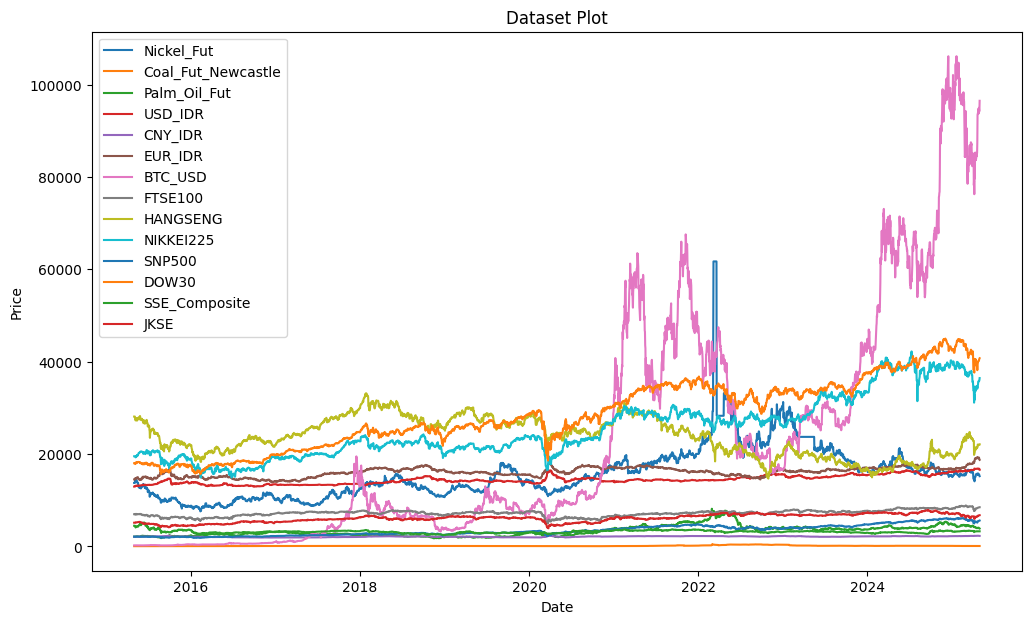

In [4]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [5]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

feature_cols = df.columns.tolist() if INCLUDE_TARGET_AS_FEATURE else [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [6]:
# scalers
X_scaler = StandardScaler().fit(train_df[feature_cols])
y_scaler = StandardScaler().fit(train_df[[TARGET_COL]])
y_mean, y_scale = float(y_scaler.mean_[0]), float(y_scaler.scale_[0])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values; y_vals = y_df.values.squeeze(); idx = X_df.index
    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i]); idx_list.append(idx[i])
    return (np.array(X_list, np.float32),
            np.array(y_list, np.float32),
            np.array(idx_list))

X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST["lookback"])
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST["lookback"])
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST["lookback"])

In [7]:
# ---------------------- Transformer quantile model ----------------------
class SinusoidalPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
    def call(self, x):
        L = tf.shape(x)[1]
        d = self.d_model + (self.d_model % 2)
        pos = tf.cast(tf.range(L)[:, None], tf.float32)
        i   = tf.cast(tf.range(d)[None, :], tf.float32)
        angle_rates = 1.0 / tf.pow(10000.0, (2*(i//2))/d)
        angles = pos * angle_rates
        sines = tf.sin(angles[:, 0::2]); coses = tf.cos(angles[:, 1::2])
        pe = tf.concat([sines, coses], axis=-1)[:, :self.d_model]
        return x + pe[None, :, :]

def encoder_block(x, num_heads, d_model, dff, dropout_rate):
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn_out)])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)
    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer_quantile(lookback, n_features, d_model, num_heads, dff, num_layers, dropout, lr):
    inp = Input(shape=(lookback, n_features))
    x = Dense(d_model)(inp)                                # token projection
    x = SinusoidalPositionalEncoding(d_model)(x)
    for _ in range(num_layers):
        x = encoder_block(x, num_heads=num_heads, d_model=d_model, dff=dff, dropout_rate=dropout)
    x = Lambda(lambda t: t[:, -1, :])(x)                   # last step pooling
    out = Dense(len(TAUS))(x)                              # quantile head (standardized)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=None)  # set with pinball
    return model

In [8]:
# ---------------------- Pinball loss (multi-quantile) ----------------------
def pinball_multi(taus):
    taus = tf.constant(taus, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_t = tf.expand_dims(y_true, axis=-1)
        e   = y_t - y_pred
        l   = tf.maximum(taus*e, (taus-1.0)*e)
        return tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    return loss

def compile_member():
    m = build_transformer_quantile(
        lookback=BEST["lookback"], n_features=len(feature_cols),
        d_model=BEST["d_model"], num_heads=BEST["num_heads"], dff=BEST["dff"],
        num_layers=BEST["num_layers"], dropout=BEST["dropout"], lr=BEST["lr"]
    )
    m.compile(optimizer=optimizers.Adam(learning_rate=BEST["lr"]),
              loss=pinball_multi(TAUS))
    return m

In [9]:
# ---------------------- Ensemble training ----------------------
def bootstrap_idx(n, seed):
    rng = np.random.default_rng(seed)
    return rng.integers(0, n, size=n)

def train_member(seed):
    print(f"\nTraining member with seed {seed} ...")
    tf.keras.utils.set_random_seed(seed)
    member = compile_member()
    if BOOTSTRAP:
        idx_bs = bootstrap_idx(len(X_train_w), seed+777)
        Xb, yb = X_train_w[idx_bs], y_train_w[idx_bs]
    else:
        Xb, yb = X_train_w, y_train_w
    cbs = [
        EarlyStopping(monitor="val_loss", patience=BEST["patience"], restore_best_weights=True),
        ModelCheckpoint(f"transformer_cqr_member_{seed}.keras", monitor="val_loss", save_best_only=True)
    ]
    member.fit(Xb, yb,
               validation_data=(X_val_w, y_val_w),
               epochs=BEST["epochs"], batch_size=BEST["batch_size"],
               verbose=1, callbacks=cbs)
    return member

print(f"\nTraining Transformer+CQR ensemble with M={M_ENSEMBLE} ...")
members = [train_member(SEED_BASE + 137*i) for i in range(M_ENSEMBLE)]


Training Transformer+CQR ensemble with M=5 ...

Training member with seed 42 ...



Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - loss: 1.5811 - val_loss: 1.2291
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.6157 - val_loss: 0.5126
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3130 - val_loss: 0.7660
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2128 - val_loss: 0.9530
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1733 - val_loss: 1.1078
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.1450 - val_loss: 1.0900
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.1263 - val_loss: 0.6785
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.1059 - val_loss: 0.7556
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.1017 - val_loss: 0.6231
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.1016 - val_loss: 0.6344

Training member with seed 179 ...
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - loss: 1.2918 - val_loss: 0.4203
Epoch 2/30
19/19 ━━━━━━━

In [10]:
# ---------------------- Predict quantiles per member & inverse-scale ----------------------
def predict_quantiles_member(m, X, idx):
    qz = m.predict(X, verbose=0)           # (N,3) standardized
    qy = qz * y_scale + y_mean             # inverse-scale
    qy = np.sort(qy, axis=1)               # enforce monotonicity
    return (pd.Series(qy[:,0], index=idx),
            pd.Series(qy[:,1], index=idx),
            pd.Series(qy[:,2], index=idx))

def predict_all(members, X, idx):
    Ls, Ms, Us = [], [], []
    for m in members:
        qL, qM, qU = predict_quantiles_member(m, X, idx)
        Ls.append(qL.values); Ms.append(qM.values); Us.append(qU.values)
    Ls = np.stack(Ls, axis=1); Ms = np.stack(Ms, axis=1); Us = np.stack(Us, axis=1)
    L_bar = pd.Series(Ls.mean(axis=1), index=idx, name="qL_bar")
    M_bar = pd.Series(Ms.mean(axis=1), index=idx, name="qM_bar")
    U_bar = pd.Series(Us.mean(axis=1), index=idx, name="qU_bar")
    # Epistemic variance ≈ across-member variance of the median
    var_epi = pd.Series(Ms.var(axis=1, ddof=1) if Ms.shape[1]>1 else np.zeros(Ms.shape[0]),
                        index=idx, name="var_epistemic")
    # Aleatoric proxy from IQR (Gaussian approx)
    IQR = U_bar.values - L_bar.values
    sigma_alea = IQR / 3.92
    var_alea = pd.Series(np.maximum(sigma_alea, 0)**2, index=idx, name="var_aleatoric")
    return L_bar, M_bar, U_bar, var_epi, var_alea

L_tr_bar, M_tr_bar, U_tr_bar, var_epi_tr, var_alea_tr = predict_all(members, X_train_w, idx_train)
L_v_bar,  M_v_bar,  U_v_bar,  var_epi_v,  var_alea_v  = predict_all(members, X_val_w,   idx_val)
L_te_bar, M_te_bar, U_te_bar, var_epi_te, var_alea_te = predict_all(members, X_test_w,  idx_test)

actual = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

In [11]:
# ---------------------- Split Conformal Calibration (validation) ----------------------
E_val = np.maximum(L_v_bar.values - actual_val.values, actual_val.values - U_v_bar.values)
E_val = np.maximum(E_val, 0.0)
q_hat = np.quantile(E_val, 1 - ALPHA, method="higher") if hasattr(np, "quantile") \
        else np.percentile(E_val, (1-ALPHA)*100, interpolation="higher")

# Final conformalized intervals
L_train = L_tr_bar - q_hat;   U_train = U_tr_bar + q_hat
L_val   = L_v_bar  - q_hat;   U_val   = U_v_bar  + q_hat
L_test  = L_te_bar - q_hat;   U_test  = U_te_bar + q_hat

# Point forecast = ensemble median
mean_train = M_tr_bar.rename("point_pred")
mean_val   = M_v_bar.rename("point_pred")
mean_test  = M_te_bar.rename("point_pred")

In [12]:
# ---------------------- Metrics ----------------------
def base_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return dict(MSE=mse, MAE=mae, RMSE=rmse, MAPE=mape, R2=r2)

def uq_metrics(y_true, L, U, alpha=ALPHA):
    y = np.asarray(y_true); L = np.asarray(L); U = np.asarray(U)
    cover = (y >= L) & (y <= U)
    picp = cover.mean()
    mpiw = np.mean(U - L)
    penalty = np.where(y < L, (2/alpha)*(L - y),
              np.where(y > U, (2/alpha)*(y - U), 0.0))
    winkler = np.mean((U - L) + penalty)
    return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)

print("\n=== Point Forecast Metrics (median) — Transformer + CQR Ensemble ===")
print("Train:", base_metrics(actual_train.values, mean_train.values))
print("Val:  ", base_metrics(actual_val.values,   mean_val.values))
print("Test: ", base_metrics(actual_test.values,  mean_test.values))

print(f"\n=== UQ Metrics ({int((1-ALPHA)*100)}% PI) — CQR (conformalized) ===")
print("Train:", uq_metrics(actual_train.values, L_train.values, U_train.values, ALPHA))
print("Val:  ", uq_metrics(actual_val.values,   L_val.values,   U_val.values,   ALPHA))
print("Test: ", uq_metrics(actual_test.values,  L_test.values,  U_test.values,  ALPHA))


=== Point Forecast Metrics (median) — Transformer + CQR Ensemble ===
Train: {'MSE': 17410.13180051317, 'MAE': 112.16928481878476, 'RMSE': 131.94745848447846, 'MAPE': 0.01961986232866, 'R2': 0.9565104036740566}
Val:   {'MSE': 66149.0021283301, 'MAE': 212.81386485811103, 'RMSE': 257.1944830829971, 'MAPE': 0.030393467252895188, 'R2': -0.426070379489065}
Test:  {'MSE': 225230.10235156125, 'MAE': 410.03571705759975, 'RMSE': 474.5841362198712, 'MAPE': 0.056640956602308924, 'R2': -0.9864684269677231}

=== UQ Metrics (95% PI) — CQR (conformalized) ===
Train: {'PICP': 1.0, 'MPIW': 1481.8829, 'Winkler': 1481.883083279846}
Val:   {'PICP': 1.0, 'MPIW': 1619.144, 'Winkler': 1619.1440732236983}
Test:  {'PICP': 0.9642365887207703, 'MPIW': 1638.2247, 'Winkler': 1709.9859928982546}


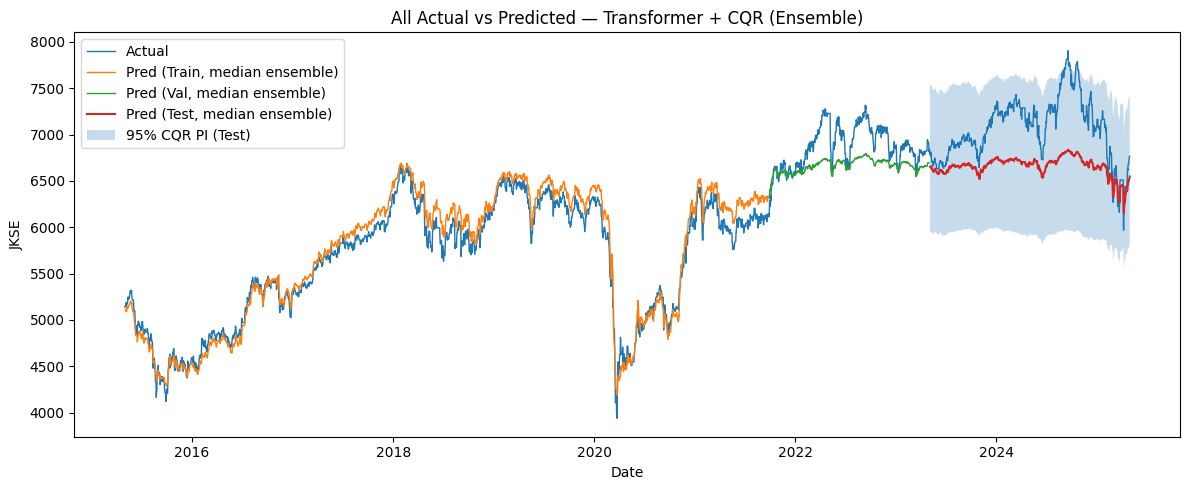

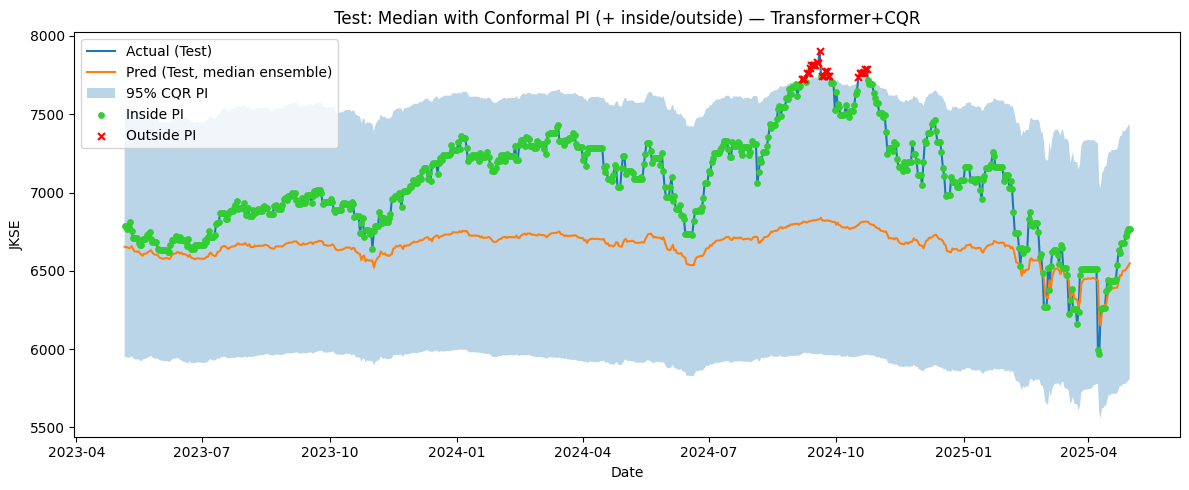

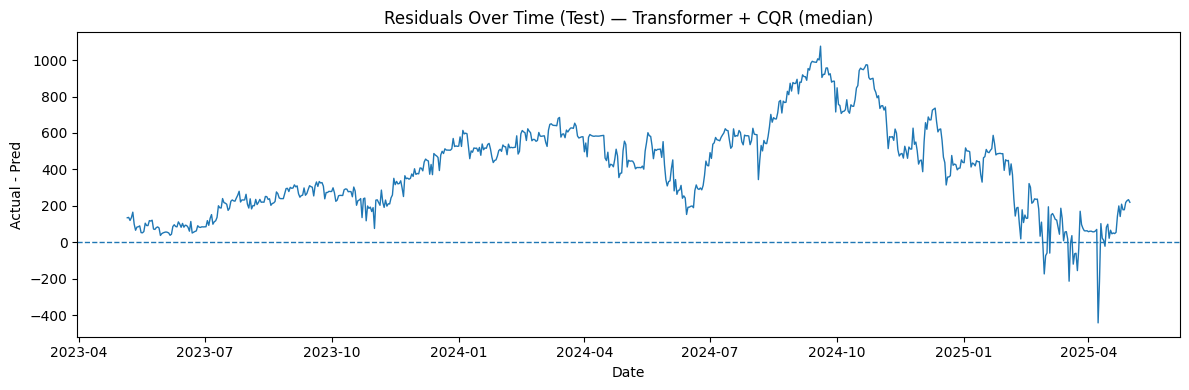

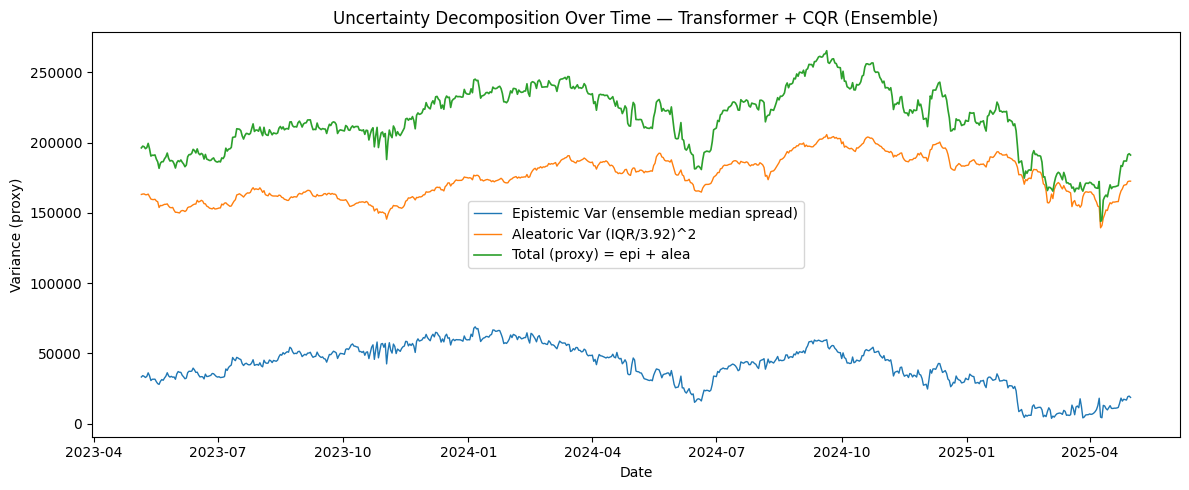

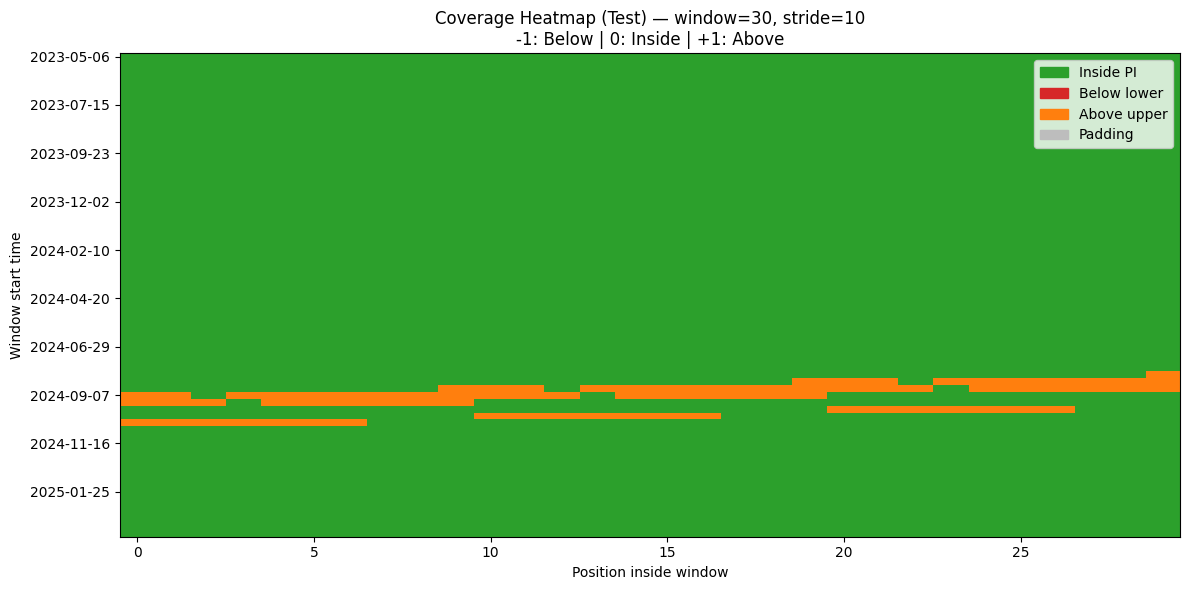

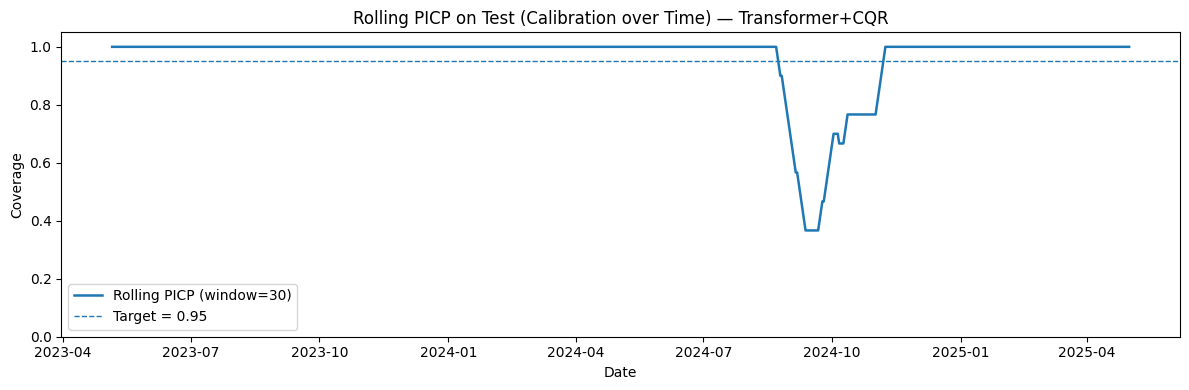

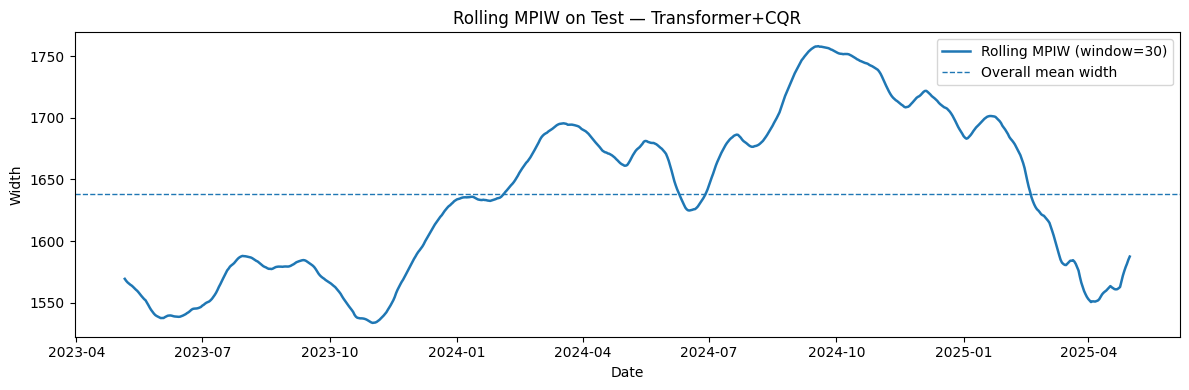

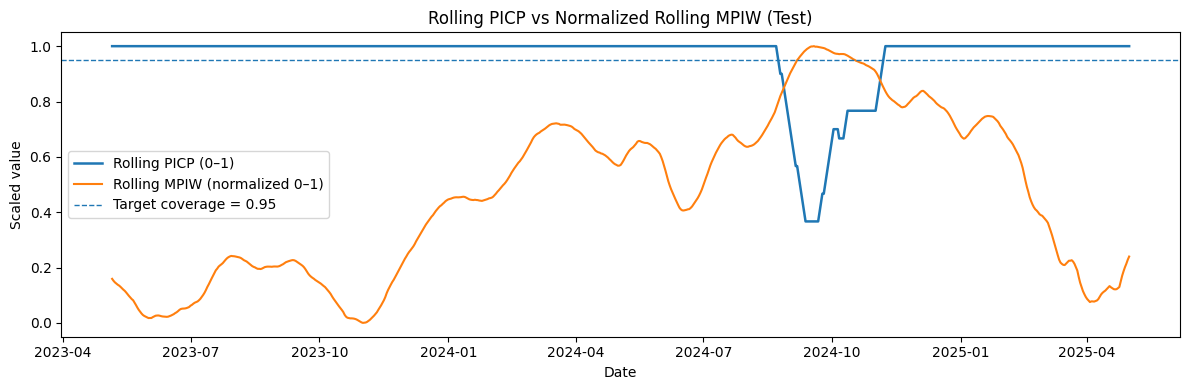


=== Summary (Point + UQ) — Transformer + Conformal Quantile Regression (Ensemble) ===
Split         MSE      MAE     RMSE   MAPE      R2   PICP        MPIW   Winkler
Train  17410.1318 112.1693 131.9475 0.0196  0.9565 1.0000 1481.882935 1481.8831
  Val  66149.0021 212.8139 257.1945 0.0304 -0.4261 1.0000 1619.144043 1619.1441
 Test 225230.1024 410.0357 474.5841 0.0566 -0.9865 0.9642 1638.224731 1709.9860


In [13]:
# ---------------------- Visualizations ----------------------
def classify_inside_outside(y_true_s, L_s, U_s):
    y = np.asarray(y_true_s); L = np.asarray(L_s); U = np.asarray(U_s)
    inside = (y >= L) & (y <= U)
    return inside, ~inside

# 1) Full series view
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual.values, label="Actual", linewidth=1)
plt.plot(mean_train.index, mean_train.values, label="Pred (Train, median ensemble)", linewidth=1)
plt.plot(mean_val.index,   mean_val.values,   label="Pred (Val, median ensemble)", linewidth=1)
plt.plot(mean_test.index,  mean_test.values,  label="Pred (Test, median ensemble)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.25,
                 label=f"{int((1-ALPHA)*100)}% CQR PI (Test)")
plt.title("All Actual vs Predicted — Transformer + CQR (Ensemble)")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 2) Test horizon with inside/outside markers
inside_mask, outside_mask = classify_inside_outside(actual_test.values, L_test.values, U_test.values)
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mean_test.index,   mean_test.values,   label="Pred (Test, median ensemble)", linewidth=1.5)
plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.30, label=f"{int((1-ALPHA)*100)}% CQR PI")
plt.scatter(actual_test.index[inside_mask],  actual_test.values[inside_mask],  s=15, label="Inside PI", zorder=3, color="limegreen")
plt.scatter(actual_test.index[outside_mask], actual_test.values[outside_mask], s=25, marker="x", label="Outside PI", zorder=3, color="red")
plt.title("Test: Median with Conformal PI (+ inside/outside) — Transformer+CQR")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

# 3) Residuals (median-as-point)
residuals_test = pd.Series(actual_test.values - mean_test.values, index=actual_test.index, name="Residuals")
plt.figure(figsize=(12,4))
plt.plot(residuals_test.index, residuals_test.values, linewidth=1)
plt.axhline(0, ls="--", lw=1); plt.title("Residuals Over Time (Test) — Transformer + CQR (median)")
plt.xlabel("Date"); plt.ylabel("Actual - Pred"); plt.tight_layout(); plt.show()

# 4) Uncertainty decomposition over time
var_total_te = pd.Series((var_epi_te.values + var_alea_te.values), index=idx_test, name="var_total")
plt.figure(figsize=(12,5))
plt.plot(var_epi_te.index,  var_epi_te.values,  label="Epistemic Var (ensemble median spread)", linewidth=1)
plt.plot(var_alea_te.index, var_alea_te.values, label="Aleatoric Var (IQR/3.92)^2", linewidth=1)
plt.plot(var_total_te.index, var_total_te.values, label="Total (proxy) = epi + alea", linewidth=1.2)
plt.title("Uncertainty Decomposition Over Time — Transformer + CQR (Ensemble)")
plt.xlabel("Date"); plt.ylabel("Variance (proxy)"); plt.legend(); plt.tight_layout(); plt.show()

# 5) Coverage heatmap (per-window)
from matplotlib.colors import ListedColormap, BoundaryNorm
y_true = actual_test.values; L_arr = L_test.values; U_arr = U_test.values
below_mask = (y_true < L_arr); above_mask = (y_true > U_arr); inside_mask = (y_true >= L_arr) & (y_true <= U_arr)
status = np.zeros_like(y_true, dtype=int); status[below_mask] = -1; status[above_mask] = 1
starts = np.arange(0, len(status)-HEAT_WIN+1, HEAT_STRIDE)
if len(starts) == 0: starts = np.array([0]); HEAT_WIN = len(status)
mat = []; x_tick_labels = []
for s in starts:
    e = min(s + HEAT_WIN, len(status)); row = status[s:e]
    if e - s < HEAT_WIN: row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row); x_tick_labels.append(actual_test.index[s].strftime('%Y-%m-%d'))
mat = np.vstack(mat)
cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]; norm = BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(12,6))
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window"); plt.ylabel("Window start time")
yticks = np.arange(0, len(starts), max(1, len(starts)//10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding")
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

# 6) Rolling PICP & Rolling MPIW
inside_series = pd.Series(((y_true >= L_arr) & (y_true <= U_arr)).astype(int), index=actual_test.index, name="inside")
rolling_picp = inside_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label=f"Rolling PICP (window={ROLL_LEN})")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target = {1-ALPHA:.2f}")
plt.ylim(0, 1.05)
plt.title("Rolling PICP on Test (Calibration over Time) — Transformer+CQR")
plt.xlabel("Date"); plt.ylabel("Coverage"); plt.legend(); plt.tight_layout(); plt.show()

width_series   = pd.Series((U_arr - L_arr), index=actual_test.index, name="PI_width")
rolling_mpiw   = width_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
overall_mpiw_t = width_series.mean()
plt.figure(figsize=(12,4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, linewidth=1.8, label=f"Rolling MPIW (window={ROLL_LEN})")
plt.axhline(overall_mpiw_t, ls="--", lw=1, label="Overall mean width")
plt.title("Rolling MPIW on Test — Transformer+CQR")
plt.xlabel("Date"); plt.ylabel("Width"); plt.legend(); plt.tight_layout(); plt.show()

# (Optional) If you want a normalized comparison with Rolling PICP in a separate plot:
norm_mpiw = (rolling_mpiw - np.nanmin(rolling_mpiw)) / (np.nanmax(rolling_mpiw) - np.nanmin(rolling_mpiw) + 1e-12)
plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label="Rolling PICP (0–1)")
plt.plot(norm_mpiw.index, norm_mpiw.values, linewidth=1.5, label="Rolling MPIW (normalized 0–1)")
plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
plt.title("Rolling PICP vs Normalized Rolling MPIW (Test)")
plt.xlabel("Date"); plt.ylabel("Scaled value")
plt.legend(); plt.tight_layout(); plt.show()

# ---------------------- Compact summary table ----------------------
def table_metrics():
    rows = []
    for tag, y_true_s, y_pred_s, L_s, U_s in [
        ("Train", actual_train, mean_train, L_train, U_train),
        ("Val",   actual_val,   mean_val,   L_val,   U_val),
        ("Test",  actual_test,  mean_test,  L_test,  U_test),
    ]:
        b = base_metrics(y_true_s.values, y_pred_s.values)
        u = uq_metrics(y_true_s.values, L_s.values, U_s.values, ALPHA)
        rows.append({"Split": tag, **{k: round(v,4) for k,v in b.items()},
                     "PICP": round(u["PICP"],4), "MPIW": round(u["MPIW"],4), "Winkler": round(u["Winkler"],4)})
    return pd.DataFrame(rows)

summary_df = table_metrics()
print("\n=== Summary (Point + UQ) — Transformer + Conformal Quantile Regression (Ensemble) ===")
print(summary_df.to_string(index=False))